In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.from_numpy(sequences.astype(np.float32))
        self.targets = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class StockPredictor(nn.Module):
    def __init__(self, input_features=5, hidden_size=32):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_size, 2, batch_first=True, dropout=0.1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.classifier(lstm_out[:, -1, :])

class GenericStockTargetPredictor:
    def __init__(self, symbol='AAPL', days_ahead=7):
        if not ALPHA_VANTAGE_API_KEY:
            raise ValueError("ALPHA_VANTAGE_API_KEY not found in environment variables!")
        
        self.symbol = symbol.upper()
        self.days_ahead = days_ahead
        self.api_key = ALPHA_VANTAGE_API_KEY
        self.lookback_days = 15
        self.scaler = StandardScaler()
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.current_price = None
        
        print(f"Stock Target Predictor - {self.symbol} ({days_ahead} days)")
    
    def get_stock_data(self):
        """Fetch real stock data from Alpha Vantage - no fallback"""
        print(f"Fetching real data for {self.symbol}...")
        
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={self.symbol}&apikey={self.api_key}&outputsize=full"
        
        response = requests.get(url, timeout=30)
        data = response.json()
        
        if "Time Series (Daily)" not in data:
            if "Note" in data:
                raise Exception("API call frequency limit reached. Try again later.")
            elif "Error Message" in data:
                raise Exception(f"Invalid symbol '{self.symbol}' or API error")
            else:
                raise Exception(f"API error: {data}")
        
        time_series = data["Time Series (Daily)"]
        df = pd.DataFrame(time_series).T
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        
        df_recent = df.tail(80).copy()
        self.current_price = float(df_recent['close'].iloc[-1])
        
        print(f"✓ Current {self.symbol}: ${self.current_price:.2f}")
        return df_recent
    
    def calculate_features(self, df):
        """Calculate technical features"""
        df = df.copy()
        df['returns'] = df['close'].pct_change()
        df['volatility'] = df['returns'].rolling(5).std()
        df['rsi'] = self._calculate_rsi(df['close'])
        df['sma_ratio'] = df['close'] / df['close'].rolling(10).mean()
        df['volume_ratio'] = df['volume'] / df['volume'].rolling(10).mean()
        return df.fillna(method='ffill').fillna(0)
    
    def _calculate_rsi(self, prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def create_training_data(self, df, target_percent):
        """Create training sequences for specific target"""
        feature_cols = ['returns', 'volatility', 'rsi', 'sma_ratio', 'volume_ratio']
        features = df[feature_cols].values
        
        sequences = []
        targets = []
        
        for i in range(self.lookback_days, len(df) - self.days_ahead):
            sequence = features[i-self.lookback_days:i]
            start_price = df['close'].iloc[i]
            future_prices = df['close'].iloc[i:i+self.days_ahead]
            
            if target_percent > 0:
                target = 1.0 if future_prices.max() >= start_price * (1 + target_percent/100) else 0.0
            else:
                target = 1.0 if future_prices.min() <= start_price * (1 + target_percent/100) else 0.0
            
            sequences.append(sequence)
            targets.append(target)
        
        return np.array(sequences), np.array(targets)
    
    def train_model_for_target(self, sequences, targets):
        """Train model for specific target"""
        if len(sequences) < 20:
            return 0.5  # Default probability if insufficient data
        
        original_shape = sequences.shape
        sequences_flat = sequences.reshape(-1, sequences.shape[-1])
        sequences_scaled = self.scaler.fit_transform(sequences_flat)
        sequences_scaled = sequences_scaled.reshape(original_shape)
        
        dataset = StockDataset(sequences_scaled, targets)
        loader = DataLoader(dataset, batch_size=8, shuffle=True)
        
        model = StockPredictor(input_features=sequences.shape[-1]).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        for epoch in range(30):
            model.train()
            for batch_seq, batch_targets in loader:
                batch_seq = batch_seq.to(self.device)
                batch_targets = batch_targets.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(batch_seq).squeeze()
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
        
        # Get latest prediction
        latest_sequence = sequences_scaled[-1:] 
        sequence_tensor = torch.from_numpy(latest_sequence).to(self.device)
        
        model.eval()
        with torch.no_grad():
            probability = model(sequence_tensor).cpu().numpy()[0][0]
        
        return probability
    
    def predict_all_targets(self):
        """Predict probabilities for all target ranges"""
        df = self.get_stock_data()
        df = self.calculate_features(df)
        
        # Define target ranges: 1-10% up and down
        targets_up = list(range(1, 11))  # 1% to 10% up
        targets_down = list(range(-10, 0))  # -10% to -1% down
        all_targets = targets_down + targets_up
        
        results = {}
        
        print(f"\nPredicting probabilities for {len(all_targets)} targets...")
        
        for target in all_targets:
            sequences, target_data = self.create_training_data(df, target)
            probability = self.train_model_for_target(sequences, target_data)
            results[target] = {
                'probability': probability * 100,
                'target_price': self.current_price * (1 + target/100),
                'historical_success': np.mean(target_data) * 100 if len(target_data) > 0 else 0
            }
        
        return results
    
    def display_results(self, results):
        """Display prediction results in a clean format"""
        print(f"\n{'='*70}")
        print(f"TARGET PROBABILITY ANALYSIS - {self.symbol}")
        print(f"Current Price: ${self.current_price:.2f} | Time Horizon: {self.days_ahead} days")
        print(f"{'='*70}")
        
        print(f"\n📈 UPWARD TARGETS:")
        print(f"{'Target':>6} {'Price':>8} {'Probability':>12} {'Historical':>12}")
        print("-" * 40)
        
        for target in range(1, 11):
            data = results[target]
            print(f"{target:>5}% ${data['target_price']:>7.2f} {data['probability']:>10.1f}% {data['historical_success']:>10.1f}%")
        
        print(f"\n📉 DOWNWARD TARGETS:")
        print(f"{'Target':>6} {'Price':>8} {'Probability':>12} {'Historical':>12}")
        print("-" * 40)
        
        for target in range(-1, -11, -1):
            data = results[target]
            print(f"{target:>5}% ${data['target_price']:>7.2f} {data['probability']:>10.1f}% {data['historical_success']:>10.1f}%")
        
        # Find highest probability targets
        best_up = max([t for t in range(1, 11)], key=lambda x: results[x]['probability'])
        best_down = max([t for t in range(-10, 0)], key=lambda x: results[x]['probability'])
        
        print(f"\n🎯 HIGHEST PROBABILITIES:")
        print(f"Best Upward:   {best_up:+}% ({results[best_up]['probability']:.1f}%)")
        print(f"Best Downward: {best_down:+}% ({results[best_down]['probability']:.1f}%)")
    
    def create_visualization(self, results):
        """Create visualization of probabilities"""
        targets = list(range(-10, 11))
        targets.remove(0)  # Remove 0% target
        probabilities = [results[t]['probability'] for t in targets]
        colors = ['red' if t < 0 else 'green' for t in targets]
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(targets, probabilities, color=colors, alpha=0.7)
        
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Target % Change')
        plt.ylabel('Probability (%)')
        plt.title(f'{self.symbol} - Target Achievement Probabilities ({self.days_ahead} days)')
        plt.grid(True, alpha=0.3)
        
        # Highlight highest probabilities
        max_prob = max(probabilities)
        for bar, prob in zip(bars, probabilities):
            if prob == max_prob:
                bar.set_edgecolor('black')
                bar.set_linewidth(2)
        
        plt.tight_layout()
        plt.savefig(f'{self.symbol}_target_probabilities.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_analysis(self):
        """Run complete target analysis"""
        try:
            results = self.predict_all_targets()
            self.display_results(results)
            self.create_visualization(results)
            return results
        except Exception as e:
            print(f"ERROR: {e}")
            print("Check your API key and internet connection.")
            return None

# USAGE - MODIFY THESE PARAMETERS
if __name__ == "__main__":
    # Example: AAPL targets in 7 days
    predictor = GenericStockTargetPredictor(
        symbol='AAPL',  # Change stock symbol here
        days_ahead=7    # Change time horizon here
    )
    results = predictor.run_analysis()
    
    # More examples:
    # predictor = GenericStockTargetPredictor(symbol='TSLA', days_ahead=14)
    # predictor = GenericStockTargetPredictor(symbol='SPY', days_ahead=5)

NameError: name 'ALPHA_VANTAGE_API_KEY' is not defined

Stock Target Predictor - AAPL (7 days)
Fetching real data for AAPL...
✓ Current AAPL: $238.47

Predicting probabilities for 20 targets...

TARGET PROBABILITY ANALYSIS - AAPL
Current Price: $238.47 | Time Horizon: 7 days

📈 UPWARD TARGETS:
Target    Price  Probability   Historical
----------------------------------------
    1% $ 240.85       47.5%       62.1%
    2% $ 243.24       87.5%       44.8%
    3% $ 245.62        2.5%       25.9%
    4% $ 248.01        0.5%       20.7%
    5% $ 250.39        0.2%       19.0%
    6% $ 252.78        0.6%       15.5%
    7% $ 255.16        0.4%        8.6%
    8% $ 257.55        0.3%        8.6%
    9% $ 259.93        0.3%        8.6%
   10% $ 262.32        0.7%        6.9%

📉 DOWNWARD TARGETS:
Target    Price  Probability   Historical
----------------------------------------
   -1% $ 236.09        4.9%       48.3%
   -2% $ 233.70       50.8%       32.8%
   -3% $ 231.32        6.5%       17.2%
   -4% $ 228.93        6.4%        6.9%
   -5% $ 226.5

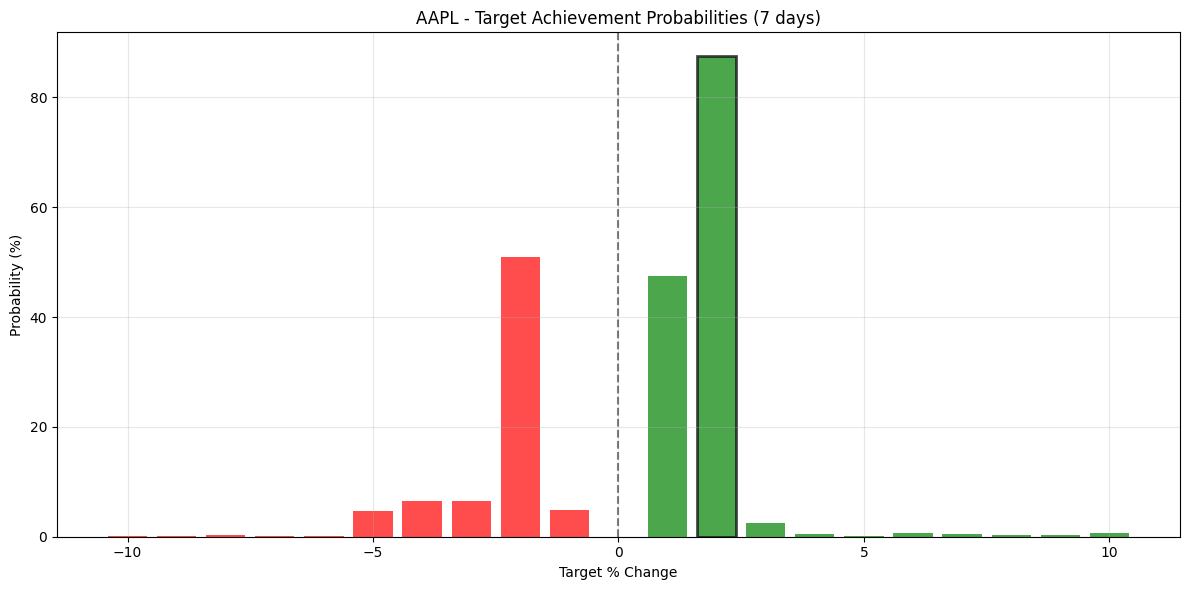

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.from_numpy(sequences.astype(np.float32))
        self.targets = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class StockPredictor(nn.Module):
    def __init__(self, input_features=5, hidden_size=32):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_size, 2, batch_first=True, dropout=0.1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.classifier(lstm_out[:, -1, :])

class GenericStockTargetPredictor:
    def __init__(self, symbol='AAPL', days_ahead=7):
        if not ALPHA_VANTAGE_API_KEY:
            raise ValueError("ALPHA_VANTAGE_API_KEY not found in environment variables!")
        
        self.symbol = symbol.upper()
        self.days_ahead = days_ahead
        self.api_key = ALPHA_VANTAGE_API_KEY
        self.lookback_days = 15
        self.scaler = StandardScaler()
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.current_price = None
        
        print(f"Stock Target Predictor - {self.symbol} ({days_ahead} days)")
    
    def get_stock_data(self):
        """Fetch real stock data from Alpha Vantage - no fallback"""
        print(f"Fetching real data for {self.symbol}...")
        
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={self.symbol}&apikey={self.api_key}&outputsize=full"
        
        response = requests.get(url, timeout=30)
        data = response.json()
        
        if "Time Series (Daily)" not in data:
            if "Note" in data:
                raise Exception("API call frequency limit reached. Try again later.")
            elif "Error Message" in data:
                raise Exception(f"Invalid symbol '{self.symbol}' or API error")
            else:
                raise Exception(f"API error: {data}")
        
        time_series = data["Time Series (Daily)"]
        df = pd.DataFrame(time_series).T
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        
        df_recent = df.tail(80).copy()
        self.current_price = float(df_recent['close'].iloc[-1])
        
        print(f"✓ Current {self.symbol}: ${self.current_price:.2f}")
        return df_recent
    
    def calculate_features(self, df):
        """Calculate technical features"""
        df = df.copy()
        df['returns'] = df['close'].pct_change()
        df['volatility'] = df['returns'].rolling(5).std()
        df['rsi'] = self._calculate_rsi(df['close'])
        df['sma_ratio'] = df['close'] / df['close'].rolling(10).mean()
        df['volume_ratio'] = df['volume'] / df['volume'].rolling(10).mean()
        return df.fillna(method='ffill').fillna(0)
    
    def _calculate_rsi(self, prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def create_training_data(self, df, target_percent):
        """Create training sequences for specific target"""
        feature_cols = ['returns', 'volatility', 'rsi', 'sma_ratio', 'volume_ratio']
        features = df[feature_cols].values
        
        sequences = []
        targets = []
        
        for i in range(self.lookback_days, len(df) - self.days_ahead):
            sequence = features[i-self.lookback_days:i]
            start_price = df['close'].iloc[i]
            future_prices = df['close'].iloc[i:i+self.days_ahead]
            
            if target_percent > 0:
                target = 1.0 if future_prices.max() >= start_price * (1 + target_percent/100) else 0.0
            else:
                target = 1.0 if future_prices.min() <= start_price * (1 + target_percent/100) else 0.0
            
            sequences.append(sequence)
            targets.append(target)
        
        return np.array(sequences), np.array(targets)
    
    def train_model_for_target(self, sequences, targets):
        """Train model for specific target"""
        if len(sequences) < 20:
            return 0.5  # Default probability if insufficient data
        
        original_shape = sequences.shape
        sequences_flat = sequences.reshape(-1, sequences.shape[-1])
        sequences_scaled = self.scaler.fit_transform(sequences_flat)
        sequences_scaled = sequences_scaled.reshape(original_shape)
        
        dataset = StockDataset(sequences_scaled, targets)
        loader = DataLoader(dataset, batch_size=8, shuffle=True)
        
        model = StockPredictor(input_features=sequences.shape[-1]).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        for epoch in range(30):
            model.train()
            for batch_seq, batch_targets in loader:
                batch_seq = batch_seq.to(self.device)
                batch_targets = batch_targets.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(batch_seq).squeeze()
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
        
        # Get latest prediction
        latest_sequence = sequences_scaled[-1:] 
        sequence_tensor = torch.from_numpy(latest_sequence.astype(np.float32)).to(self.device)
        model.eval()
        with torch.no_grad():
            probability = model(sequence_tensor).cpu().numpy()[0][0]
        
        return probability
    
    def predict_all_targets(self):
        """Predict probabilities for all target ranges"""
        df = self.get_stock_data()
        df = self.calculate_features(df)
        
        # Define target ranges: 1-10% up and down
        targets_up = list(range(1, 11))  # 1% to 10% up
        targets_down = list(range(-10, 0))  # -10% to -1% down
        all_targets = targets_down + targets_up
        
        results = {}
        
        print(f"\nPredicting probabilities for {len(all_targets)} targets...")
        
        for target in all_targets:
            sequences, target_data = self.create_training_data(df, target)
            probability = self.train_model_for_target(sequences, target_data)
            results[target] = {
                'probability': probability * 100,
                'target_price': self.current_price * (1 + target/100),
                'historical_success': np.mean(target_data) * 100 if len(target_data) > 0 else 0
            }
        
        return results
    
    def display_results(self, results):
        """Display prediction results in a clean format"""
        print(f"\n{'='*70}")
        print(f"TARGET PROBABILITY ANALYSIS - {self.symbol}")
        print(f"Current Price: ${self.current_price:.2f} | Time Horizon: {self.days_ahead} days")
        print(f"{'='*70}")
        
        print(f"\n📈 UPWARD TARGETS:")
        print(f"{'Target':>6} {'Price':>8} {'Probability':>12} {'Historical':>12}")
        print("-" * 40)
        
        for target in range(1, 11):
            data = results[target]
            print(f"{target:>5}% ${data['target_price']:>7.2f} {data['probability']:>10.1f}% {data['historical_success']:>10.1f}%")
        
        print(f"\n📉 DOWNWARD TARGETS:")
        print(f"{'Target':>6} {'Price':>8} {'Probability':>12} {'Historical':>12}")
        print("-" * 40)
        
        for target in range(-1, -11, -1):
            data = results[target]
            print(f"{target:>5}% ${data['target_price']:>7.2f} {data['probability']:>10.1f}% {data['historical_success']:>10.1f}%")
        
        # Find highest probability targets
        best_up = max([t for t in range(1, 11)], key=lambda x: results[x]['probability'])
        best_down = max([t for t in range(-10, 0)], key=lambda x: results[x]['probability'])
        
        print(f"\n🎯 HIGHEST PROBABILITIES:")
        print(f"Best Upward:   {best_up:+}% ({results[best_up]['probability']:.1f}%)")
        print(f"Best Downward: {best_down:+}% ({results[best_down]['probability']:.1f}%)")
    
    def create_visualization(self, results):
        """Create visualization of probabilities"""
        targets = list(range(-10, 11))
        targets.remove(0)  # Remove 0% target
        probabilities = [results[t]['probability'] for t in targets]
        colors = ['red' if t < 0 else 'green' for t in targets]
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(targets, probabilities, color=colors, alpha=0.7)
        
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Target % Change')
        plt.ylabel('Probability (%)')
        plt.title(f'{self.symbol} - Target Achievement Probabilities ({self.days_ahead} days)')
        plt.grid(True, alpha=0.3)
        
        # Highlight highest probabilities
        max_prob = max(probabilities)
        for bar, prob in zip(bars, probabilities):
            if prob == max_prob:
                bar.set_edgecolor('black')
                bar.set_linewidth(2)
        
        plt.tight_layout()
        plt.savefig(f'{self.symbol}_target_probabilities.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_analysis(self):
        """Run complete target analysis"""
        try:
            results = self.predict_all_targets()
            self.display_results(results)
            self.create_visualization(results)
            return results
        except Exception as e:
            print(f"ERROR: {e}")
            print("Check your API key and internet connection.")
            return None

# USAGE - MODIFY THESE PARAMETERS
if __name__ == "__main__":
    # Example: AAPL targets in 7 days
    predictor = GenericStockTargetPredictor(
        symbol='AAPL',  # Change stock symbol here
        days_ahead=7    # Change time horizon here
    )
    results = predictor.run_analysis()
    
    # More examples:
    # predictor = GenericStockTargetPredictor(symbol='TSLA', days_ahead=14)
    # predictor = GenericStockTargetPredictor(symbol='SPY', days_ahead=5)